### Transfer Learning
Checking if we have the right versions

#### Importing the necessary libraries

In [4]:
try:
    import torch
    import torchvision
    assert(int(torch.__version__.split('.')[0]) >= 2 or int(torch.__version__.split(".")[1]) >= 12, "torch version must be greater than 1.12")
    assert(int(torchvision.__version__.split(".")[1]) >= 13, "torch version must be greater than 0.13")
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.1+cu121
torchvision version: 0.16.1+cu121


<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_52073/2401564698.py:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(int(torch.__version__.split('.')[0]) >= 2 or int(torch.__version__.split(".")[1]) >= 12, "torch version must be greater than 1.12")
/tmp/ipykernel_52073/2401564698.py:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(int(torchvision.__version__.split(".")[1]) >= 13, "torch version must be greater than 0.13")


In [5]:
import matplotlib as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Importing torchinfo, installing if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Could not find torchinfo... Downloading it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it form GitHub if it doesn't work

# try:
#     from modular_version import data_setup, engine
# except:
#     # Get the going_modular scripts
#     print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
#     !git clone https://github.com/mrdbourke/pytorch-deep-learning
#     !mv pytorch-deep-learning/going_modular .
#     !rm -rf pytorch-deep-learning
#     from going_modular.going_modular import data_setup, engine
    
from modular_version import data_setup, engine

/home/umer/umer_projects/torch_tutor/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Seting up the Device Agnostic Code

In [6]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Get Data

In [7]:
import os
import zipfile

from pathlib import Path
import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists")

else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Downloading pizza, steak and sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)
    
    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")    

data/pizza_steak_sushi directory already exists


Creating paths to our training and test directories

In [8]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

### Creating Datasets and DataLoaders

Since we will use a pretrained model from torchvision.models, there's a specific transform we need to prepare our images first.

#### Creating a transform for `torchvision.models` in Manual Way

We will try an automatic way as well

In [9]:
# Create a transforms pipeline manually

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Reshape all image to 224x224
    transforms.ToTensor(), # This will turn image to values between 0 and 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#### Setting up the DataLoaders

In [10]:
# Create training and test dataloaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32,
                                                                               )

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f1cbc6fa1d0>,
 ['pizza', 'steak', 'sushi'])

### Creating a transform for `torchvision.models` (auto creation)

We will first import the model weights from `torchvision.models` and then we will access the transforms associated with its weights using the `.transforms()` method. 

In [11]:
# Get a set of pretrained model weights
weights =  torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT means the best available weights from the pretrainined on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [12]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

Notice how auto_transforms is very similar to manual_transforms, the only difference is that auto_transforms came with the model architecture we chose, where as we had to create manual_transforms by hand.

The benefit of automatically creating a transform through weights.transforms() is that you ensure you're using the same data transformation as the pretrained model used when it was trained.

However, the tradeoff of using automatically created transforms is a lack of customization.

We can use auto_transforms to create DataLoaders with create_dataloaders() just as before.

In [13]:
# Create training and testing DataLoaders as well as get a list of class names

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               batch_size=32,
                                                                               transform=auto_transforms)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f1cbc6fbc70>,
 ['pizza', 'steak', 'sushi'])

### Getting the EfficientNet_b0
Since we're working on a computer vision problem (image classification with FoodVision Mini), we can find pretrained classification models in `torchvision.models`.

The pretrained model that we will use `torchvision.models.efficientnet_b0()`

In [14]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

#model # uncomment to output (it's very long)

In [15]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

#### Getting the summary of our model using the `torchinfo.summary()`

In order to learn more about our model, we will use `torchinfo`s `summary()` method.

**Note:** Many modern models can handle input images of varying sizes thanks to `torch.nn.AdaptiveAvgPool2d()`, this layer adaptively adjusts the output_size of a given input as required.

In [16]:
# Print a summary using torchinfo
summary(model=model,
        input_size= (32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

#### Freezing the base model and changing the output layer to suit our needs

To freeze layers means to keep them how they are during training. For example, if your model has pretrained layers, to freeze them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

- We shall freeze the layers/parameters in the features section of our model.
- The layers/parameters in the features section can be freezed by setting the `reqires_grad=False`.
- For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters with `requires_grad=False` is "untrainable" or "frozen" in place. 


In [17]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False.
for param in model.features.parameters():
    param.requires_grad = False

Using the piece of code above, we have successfully frozen the feature extractor layers.

- Now we would adjust the output layers of the `classifier` portion of the model to our needs. 
- Currently our pretrained model has `out_features=1000` because there are 1000 classes in ImageNet.
- We can change the `classifier` portion of the model by creating a new series of layers.
- we will keep the `in_features=1280` for our `Linear` output layer but we'll change the `out_features` value to the length of our `class_names` `(len['pizza', 'steak', 'sushi']) = 3)`.
- Moreover, our new `classifier` layer should be on the same device as our `model`.

In [18]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the lenght of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # Same number of outpuyt units as our number of classes
                    bias=True)).to(device)

The output layer has been updated, now let's get another summary of our model to see what has changed.

In [19]:
# Do a summary after freezing the featute extractor layer and updating the output shape
summary(model=model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### Train Model

We now have a pretrained model thta is semi-frozen and has a customised `classifier`.

We'll start by setting the loss function and an optimizer, since we are working with multiclass classification, we will ise `nn.CrossEntropyLoss()` and `torch.optim.Adam()` as our optimizer with `lr=0.001`.

In [20]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In order to train our model we will make use of the `train()` function present inside the `engine.py` script inside the `modular_version` directory.

**Note:** we will only train the `classifier` parameter here as all of the other parameters in our model have been frozen.

In [21]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds.")

 20%|██        | 1/5 [00:03<00:14,  3.70s/it]

Epoch: 1 | train_loss: 1.0916 | train_acc: 0.3828 | test_loss: 0.9098 | test_acc: 0.5909


 40%|████      | 2/5 [00:06<00:09,  3.11s/it]

Epoch: 2 | train_loss: 0.8751 | train_acc: 0.7656 | test_loss: 0.7918 | test_acc: 0.8456


 60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

Epoch: 3 | train_loss: 0.7663 | train_acc: 0.8047 | test_loss: 0.7466 | test_acc: 0.8352


 80%|████████  | 4/5 [00:11<00:02,  2.77s/it]

Epoch: 4 | train_loss: 0.7219 | train_acc: 0.7461 | test_loss: 0.6381 | test_acc: 0.8551


100%|██████████| 5/5 [00:14<00:00,  2.83s/it]

Epoch: 5 | train_loss: 0.6283 | train_acc: 0.7734 | test_loss: 0.6296 | test_acc: 0.8665
[INFO] Total training time: 14.167 seconds.


This model has been able to acheive a much better test accuracy (85%) as comapared to our TinyVGG model.

### Evaluate model by plotting loss curves
We will use the `plot_loss_curves()` function from the `helper_functions.py` script for this.

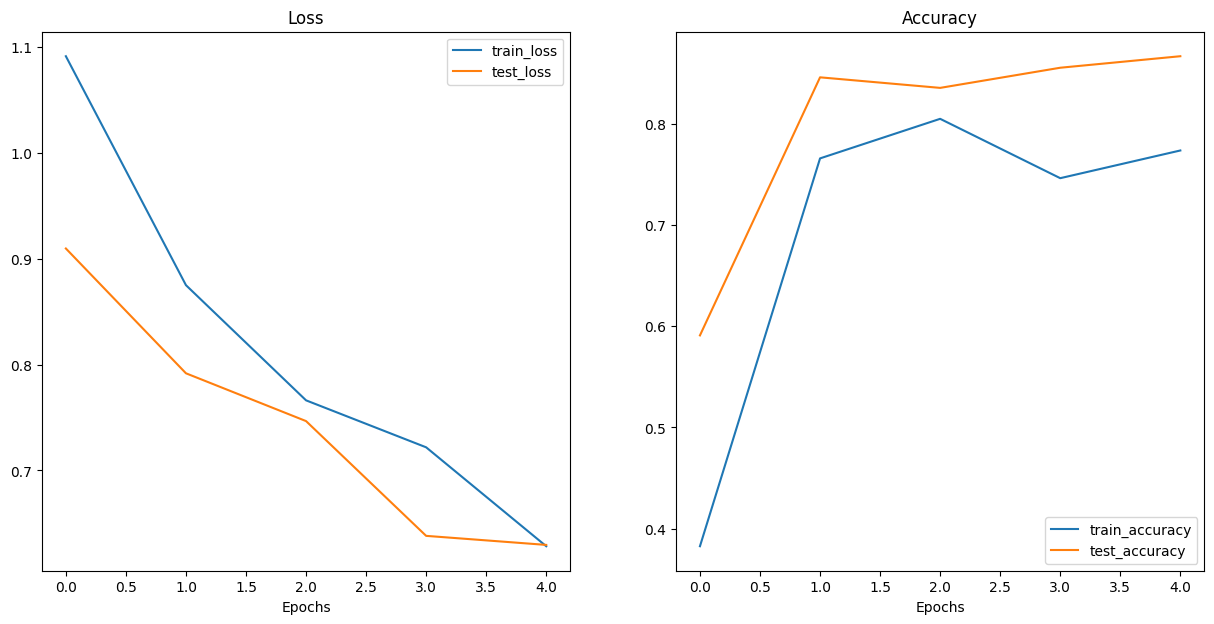

In [22]:
# Get the plot_loss_curves() function from the `helper_functions.py` script or download
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Could'nt find helper functions.py, downloading ...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

### Make Predicitons on Images from the Test Set


In [23]:
from typing import List, Tuple

from PIL import Image

# Take in an trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):

    # Open Image
    img = Image.open(image_path)

    # Create transformations for the image (if one doesnt exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on Image ###
    # Make sure that the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform the image and add an extra dimension to image (model requires the batch dimension as well)
        # [batch_size, color_channels, height, width]
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torhc.softmax() for the multiclass classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert predicition probabilities -> prediction labels
    target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)